In [1]:
%%javascript 
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [2]:
# lib
import os
import gc
import random
import math
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

#import warnings
#warnings.filterwarnings("ignore")

from fastprogress import master_bar, progress_bar
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

if not os.path.exists('models1'):
    os.mkdir('models1')


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


SEED = 777
seed_everything(SEED)

torch.__version__

'1.7.0'

In [3]:
data_path = '../input/lish-moa/'

In [4]:
def get_logger(filename='log', save=True):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    
    if save:
        handler2 = FileHandler(filename=f"{filename}.log")
        handler2.setFormatter(Formatter("%(message)s"))  
        logger.addHandler(handler2)
    return logger

logger = get_logger(nb_name[:-6])
logger.info(f'file_name: {nb_name[:-6]}')
logger.info(f'Time: {time.ctime()}')
logger.info(f'Set seed: {SEED}')

file_name: 01_baseline-opt
Time: Wed Nov 11 16:02:16 2020
Set seed: 777


# load df

In [5]:
# load df
# train_df
trn_feature = pd.read_csv(data_path + 'train_features.csv')
print(trn_feature.shape)

# train_df_target
trn_tar_df = pd.read_csv(data_path + 'train_targets_scored.csv')
print(trn_tar_df.shape)

# test_df
test_df = pd.read_csv(data_path + 'test_features.csv')
print(test_df.shape)

# sub_df
sub_df = pd.read_csv(data_path + 'sample_submission.csv')
print(sub_df.shape)

# label column keys
y_keys = list(trn_tar_df.keys())[1:];

# numerical col
genes = [col for col in trn_feature.columns if col.startswith('g-')]
cells = [col for col in trn_feature.columns if col.startswith('c-')]

# catgoriacal col
cat_col = ['cp_time', 'cp_dose']

(23814, 876)
(23814, 207)
(3982, 876)
(3982, 207)


In [6]:
# create df without ctl_vehicle in cp_type
trn_df = trn_feature.merge(trn_tar_df, on='sig_id')
trn_df = trn_df[trn_df.cp_type !='ctl_vehicle'].reset_index(drop=True)
test_df = test_df[test_df.cp_type !='ctl_vehicle'].reset_index(drop=True)
print(trn_df.shape, test_df.shape)
trn_df.sample(20)

(21948, 1082) (3624, 876)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
14261,id_a6a4f3626,trt_cp,24,D2,-0.3265,0.1577,-0.3381,0.1789,0.2595,0.7117,...,0,0,0,0,0,0,0,0,0,0
14266,id_a6b456ebb,trt_cp,24,D1,-0.7239,0.0713,0.2250,0.5864,2.6280,-0.4762,...,0,0,0,0,0,0,0,0,0,0
5119,id_3bd739795,trt_cp,24,D1,0.5283,1.2350,2.7150,-0.0206,0.5865,0.2824,...,0,0,0,0,0,0,0,0,0,0
692,id_07b7426b2,trt_cp,24,D1,-0.2856,-0.6573,1.8890,-0.3083,-0.5899,0.5369,...,0,0,0,0,0,0,0,0,0,0
6833,id_4fbf1ada4,trt_cp,72,D2,0.9492,-0.5027,-0.0934,-2.2830,-0.1903,0.0230,...,0,0,0,0,0,0,0,0,0,0
7051,id_52620ac73,trt_cp,24,D1,-0.4717,-0.2592,-0.5129,0.0462,0.5863,-0.6585,...,0,0,0,0,0,0,0,0,0,0
13131,id_995a3b2d4,trt_cp,48,D1,2.4190,-1.1380,-0.4596,-0.1602,2.5480,1.5230,...,0,0,0,0,0,0,0,0,0,0
2435,id_1c33757b3,trt_cp,24,D1,-0.0171,-0.0432,-0.4036,-0.6486,-0.7183,-0.5947,...,0,0,0,0,0,0,0,0,0,0
10021,id_7514b50fb,trt_cp,48,D1,0.5772,0.8006,1.5080,-0.8161,-0.1879,-0.1965,...,0,0,0,0,0,0,0,0,0,0
13768,id_a0ad27715,trt_cp,48,D2,0.2120,0.2485,1.0300,-1.0730,-0.0180,-1.7210,...,0,0,0,0,0,0,0,0,0,0


# cv

In [7]:
# kfolds index
folds = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for n, (trn_idx, val_idx) in enumerate(folds.split(trn_df, trn_df[y_keys])):
    print(trn_idx, val_idx)

C:\Users\utl\anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass shuffle=True, random_state=777 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[    0     1     2 ... 21945 21946 21947] [    3    15    21 ... 21939 21942 21944]
[    1     2     3 ... 21944 21945 21947] [    0     4     7 ... 21934 21936 21946]
[    0     2     3 ... 21945 21946 21947] [    1    14    18 ... 21928 21940 21943]
[    0     1     2 ... 21944 21946 21947] [    8     9    10 ... 21920 21932 21945]
[    0     1     3 ... 21944 21945 21946] [    2     5     6 ... 21937 21941 21947]


# dataset

In [8]:
class TrainDataset(Dataset):
    def __init__(self, df, features_col, labels_col):
        self.features = torch.FloatTensor(df[features_col].values).to(device)
        self.labels = torch.tensor(df[labels_col].values).float().to(device)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]

        return x, y


class TestDataset(Dataset):
    def __init__(self, df, features_col):
        self.features = torch.FloatTensor(df[features_col].values)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx].to(device)

        return x

In [9]:
cat_features = ['cp_time', 'cp_dose']
feature_cols = genes + cells + cat_features


def cate2num(df):
    df['cp_time'] = df['cp_time'].map({24: 0, 48: 1, 72: 2})
    df['cp_dose'] = df['cp_dose'].map({'D1': 1, 'D2': 0})
    return df


trn_df = cate2num(trn_df)
test_df = cate2num(test_df)

In [10]:
# debug ds, dl
trn_dataset = TrainDataset(trn_df.iloc[trn_idx], feature_cols, y_keys)
test_dataset = TestDataset(test_df, feature_cols)

trn_loader = DataLoader(trn_dataset,
                        batch_size=32,
                        shuffle=True,
                        drop_last=True)
test_loader = DataLoader(test_dataset,
                         batch_size=32,
                         shuffle=False,
                         drop_last=False)

for xs, ys in trn_loader: 
    print(xs.shape, ys.shape)
    break
for xs in test_loader: 
    print(xs.shape)
    break

torch.Size([32, 874]) torch.Size([32, 206])
torch.Size([32, 874])


# model

In [11]:
class CFG:
    max_grad_norm = 1000
    hidden_size = 256
    dropout = 0.5
    lr = 3e-3
    wd = 1e-6
    bs = 32
    epochs = 30
    smooth = 0.001
    feature_cols = feature_cols
    target_cols = y_keys
    optimizer = optim.Adam
    scheduler = None 

In [12]:
class MLP(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.h1 = nn.Sequential(
            nn.Linear(len(cfg.feature_cols), cfg.hidden_size),
            nn.Hardswish(inplace=True),
            nn.BatchNorm1d(cfg.hidden_size), 
            nn.Dropout(cfg.dropout))
        
        self.h2 = nn.Sequential(
            nn.Linear(cfg.hidden_size, cfg.hidden_size),
            nn.Hardswish(inplace=True),
            nn.BatchNorm1d(cfg.hidden_size),
            nn.Dropout(cfg.dropout),
        )
        self.h3 = nn.Linear(cfg.hidden_size, len(cfg.target_cols))

    def forward(self, x):
        x = self.h1(x)
        x = self.h2(x)
        return self.h3(x)

In [13]:
def compute_metric(preds, ys):
    esp = 1e-15
    preds = np.clip(preds, esp, 1 - esp)
    score = -np.mean(np.mean(
        ys * np.log(preds + esp) + (1 - ys) * np.log(1 - preds + esp), axis=1),
                     axis=0)
    return score


def smoothing_critirion(smooth=0.0):
    assert 0 <= smooth < 1, 'smooth not in range'

    def smoothing(criterion):
        def warp(preds, ys):
            with torch.no_grad():
                ys = ys * (1.0 - smooth) + 0.5 * smooth
            return criterion(preds, ys)

        return warp

    return smoothing


@smoothing_critirion(smooth=CFG.smooth)
def criterion(preds, ys):
    return F.binary_cross_entropy_with_logits(preds, ys)

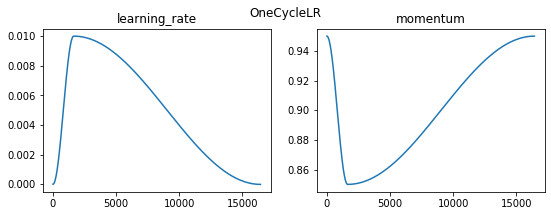

In [15]:
# show_learning_rate_scheduler
#%%capture --no-display
optim_param = {'lr': CFG.lr, 'weight_decay': CFG.wd}
CFG.optimizer = optim.Adam
CFG.optim_param = optim_param

scheduler_param = {
    'pct_start': 0.1,
    'div_factor': 1e3,
    'max_lr': 1e-2,
    'epochs': CFG.epochs,
    'steps_per_epoch': len(trn_loader)
}
CFG.scheduler = optim.lr_scheduler.OneCycleLR
CFG.scheduler_param = scheduler_param


cfg = CFG
model = MLP(cfg).to(device)
optimizer = cfg.optimizer(model.parameters(), **cfg.optim_param)
scheduler = cfg.scheduler(optimizer, **cfg.scheduler_param)

def show_learning_rate_scheduler():
    lrs = []
    moms = []
    if scheduler.__class__.__name__ == 'OneCycleLR':
        step = cfg.epochs* len(trn_loader)
    else:
        step = cfg.epochs
    
    for i in range(step):
        optimizer.step()
        lrs.append(scheduler.optimizer.param_groups[0]['lr'])
        moms.append(scheduler.optimizer.param_groups[0]['betas'][0])
        scheduler.step()

    plt.figure(figsize=(9, 3))
    plt.suptitle(scheduler.__class__.__name__)
    plt.subplot(121)
    plt.title('learning_rate')
    plt.plot(lrs)
    plt.subplot(122)
    plt.title('momentum')
    plt.plot(moms)


show_learning_rate_scheduler()

# train

In [16]:
def trn_fn(trn_loader, model, optimizer, scheduler, mb, history):

    running_loss = 0.0
    running_metric = 0.0
    m = 0

    model.train()

    trn_tqdm = progress_bar(trn_loader, total=int(len(trn_loader)), parent=mb)
    for i, (xs, ys) in enumerate(trn_tqdm):
        batch_size = len(xs)
        m += batch_size

        # forward, backward
        optimizer.zero_grad()
        preds = model(xs)
        loss = criterion(preds, ys)
        loss.backward()

        # clip grad
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                   CFG.max_grad_norm)
        optimizer.step()
        if scheduler.__class__.__name__ == 'OneCycleLR':
            scheduler.step()
            history['lrs'].append(scheduler.optimizer.param_groups[0]['lr'])

        # metric
        metric = compute_metric(preds.sigmoid().detach().cpu().numpy(), 
                                ys.detach().cpu().numpy())
        

        # to record
        running_loss += loss.item() * batch_size
        running_metric += metric * batch_size

        # set commet on child progressbar
        mb.child.comment = (f'loss={loss.item():.4f}, ' f'metric={metric:.4f}')
    
    # step if lr scheduler not onecycle
    if scheduler.__class__.__name__ != 'OneCycleLR':
        scheduler.step()    
        history['lrs'].append(scheduler.optimizer.param_groups[0]['lr'])
    return running_loss / m, running_metric / m


def val_fn(val_loader, model, mb):

    running_loss = 0.0
    running_metric = 0.0
    m = 0
    val_preds = []

    model.eval()
    
    val_tqdm = progress_bar(val_loader, total=int(len(val_loader)), parent=mb)
    for i, (xs, ys) in enumerate(val_tqdm):

        batch_size = len(xs)
        m += batch_size

        model.eval()

        # loss
        with torch.no_grad():
            preds = model(xs)
        loss = criterion(preds, ys)
        
        # metric
        preds = preds.sigmoid()
        metric = compute_metric(preds.detach().cpu().numpy(),
                                ys.detach().cpu().numpy())

        # to record
        running_loss += loss.item() * batch_size
        running_metric += metric * batch_size
        val_preds.append(preds.detach().cpu().numpy())

        # set commet on child progressbar
        mb.child.comment = (f'val_loss={loss.item():.4f}, '
                            f'val_metric={metric:.4f}')
        
    val_preds = np.concatenate(val_preds)
    return running_loss / m, running_metric / m, val_preds


def infer_fn(test_loader, model):

    model.eval()
    preds = []

    for i, xs in enumerate(test_loader):

        with torch.no_grad():
            pred = model(xs)
        
        pred = pred.sigmoid()
        preds.append(pred.detach().cpu().numpy())

    preds = np.concatenate(preds)

    return preds


def plot_history(history, fold_num=0):
    
    fig = plt.figure(figsize=(16, 3))
    fig.subplots_adjust(top=0.8)
    plt.suptitle(f'fold{fold_num}')
    
    # metrics
    plt.subplot(131)
    plt.ylim(0.01, 0.03)
    plt.plot(history['trn_metrics'], 'C0', label='train')
    plt.plot(history['val_metrics'], 'C1', label='val')
    plt.title(f'Metric')
    plt.legend()
    plt.ylabel("Metric") 
    plt.xlabel("Epoch")
    
    # loss
    plt.subplot(132)
    plt.ylim(0.01, 0.03)
    plt.plot(history['trn_losses'], 'C0', label='train')
    plt.plot(history['val_losses'], 'C1', label='val')
    plt.title(f'Loss')
    plt.legend()
    plt.ylabel("Loss") 
    plt.xlabel("Epoch")
    
    # lr
    plt.subplot(133)
    plt.plot(history['lrs'][1:], 'C0', label='lr')
    plt.title(f'Learning rate')
    plt.ylabel("Loss") 
    if history['lrs'] == 'OneCycleLR':
        plt.xlabel("Iteration")    
    else:
        plt.xlabel("Epoch")
    
    plt.show()

In [17]:
def run_single_nn(cfg,
                  trn_df,
                  test_df,
                  fold_idx,
                  feature_cols,
                  target_cols,
                  fold_num=0):
    
    # init
    best_loss = np.inf
    history = {
        'losses': [],
        'trn_losses': [],
        'trn_metrics': [],
        'val_losses': [],
        'val_metrics': [],
        'lrs': [],
    }
    mb = master_bar(range(1, cfg.epochs + 1))
    mb.write(('epoch', 'train loss', 'train metric', 'val loss', 'val metric',
              'time'),
             table=True)

    # loader
    trn_idx, val_idx = fold_idx
    trn_dataset = TrainDataset(trn_df.iloc[trn_idx], feature_cols, target_cols)
    val_dataset = TrainDataset(trn_df.iloc[val_idx], feature_cols, target_cols)
    trn_loader = DataLoader(trn_dataset,
                            batch_size=cfg.bs,
                            shuffle=True,
                            drop_last=True)
    val_loader = DataLoader(val_dataset,
                            batch_size=cfg.bs,
                            shuffle=False,
                            drop_last=False)

    # model
    model = MLP(cfg).to(device)
    optimizer = cfg.optimizer(model.parameters(), **cfg.optim_param)
    scheduler = cfg.scheduler(optimizer, **cfg.scheduler_param)
    history['lrs'].append(scheduler.__class__.__name__)

    # train & validate
    for epoch in mb:
        start_time = time.time()
        trn_loss, trn_metric = trn_fn(trn_loader, 
                                      model, 
                                      optimizer, 
                                      scheduler,
                                      mb, 
                                      history)
        val_loss, val_metric, val_preds = val_fn(val_loader, model, mb)

        # checkpoint
        if val_metric < best_loss:
            logger.info(f'epoch{epoch} save best model... {val_metric}')
            best_loss = val_metric
            oof = np.zeros((len(trn_df), len(cfg.target_cols)))
            oof[val_idx] = val_preds
            torch.save(model.state_dict(), f"fold{fold_num}_.pth")

        # calculate time
        end_time = time.time()
        m, s = divmod(end_time - start_time, 60)

        # record
        history['trn_losses'].append(trn_loss)
        history['trn_metrics'].append(trn_metric)
        history['val_losses'].append(val_loss)
        history['val_metrics'].append(val_metric)
        mb.write((f'{epoch}', f'{trn_loss:.6f}', f'{trn_metric:.10f}',
                  f'{val_loss:.6f}', f'{val_metric:.10f}', f'{m:.0f}:{s:.0f}'),
                 table=True)

    score = compute_metric(oof[val_idx],
                           trn_df.iloc[val_idx][target_cols].values)
    logger.info(f"fold{fold_num} score: {score}")
    plot_history(history, fold_num)

    # predictions
    test_dataset = TestDataset(test_df, feature_cols)
    test_loader = DataLoader(test_dataset,
                             batch_size=cfg.bs,
                             shuffle=False,
                             drop_last=False)

    model = MLP(cfg)
    model.load_state_dict(torch.load(f"fold{fold_num}_.pth"))
    model.to(device)
    predictions = infer_fn(test_loader, model)

    # del
    torch.cuda.empty_cache()

    return oof, predictions


def run_kfold_nn(cfg, trn_df, test_df, feature_cols, target_cols, n_fold=5):

    oof = np.zeros((len(trn_df), len(cfg.target_cols)))
    predictions = np.zeros((len(test_df), len(cfg.target_cols)))

    folds = MultilabelStratifiedKFold(n_splits=5,
                                      shuffle=True,
                                      random_state=SEED)
    for fold_num, (fold_idx) in enumerate(folds.split(trn_df, trn_df[y_keys])):

        logger.info(f'fold {fold_num}')
        _oof, _predictions = run_single_nn(cfg,
                                           trn_df,
                                           test_df,
                                           fold_idx,
                                           cfg.feature_cols,
                                           cfg.target_cols,
                                           fold_num=fold_num)
        oof += _oof
        predictions += _predictions / n_fold

    score = compute_metric(oof, trn_df[y_keys].values)
    logger.info(f"CV score: {score}")

    return oof, predictions

C:\Users\utl\anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass shuffle=True, random_state=777 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
fold 0


epoch,train loss,train metric,val loss,val metric,time
1,0.443663,0.4428407546,0.024868,0.0220934471,0:4
2,0.025677,0.0225631870,0.022618,0.0193339412,0:3
3,0.024742,0.0213928182,0.021978,0.0186615380,0:3
4,0.023201,0.0198969181,0.021197,0.0179427752,0:3
5,0.022351,0.0190958105,0.020850,0.0175842983,0:3
6,0.021907,0.0186618757,0.020672,0.0174272567,0:3
7,0.021667,0.0184204224,0.020485,0.0172810043,0:3
8,0.021496,0.0182339432,0.020488,0.0172400370,0:3
9,0.021414,0.0181440526,0.020482,0.0171689705,0:3
10,0.021459,0.0181901236,0.020407,0.0171846629,0:3


epoch1 save best model... 0.0220934470525703
epoch2 save best model... 0.019333941246762635
epoch3 save best model... 0.01866153798963459
epoch4 save best model... 0.017942775225007996
epoch5 save best model... 0.01758429833299614
epoch6 save best model... 0.01742725672968292
epoch7 save best model... 0.017281004347772695
epoch8 save best model... 0.017240036977348945
epoch9 save best model... 0.01716897051722015
epoch13 save best model... 0.01708965925139148
epoch15 save best model... 0.01700181548901598
epoch17 save best model... 0.01699626857928236
epoch18 save best model... 0.016890368294946695
epoch19 save best model... 0.016770312744182173
epoch20 save best model... 0.016553402404409064
epoch22 save best model... 0.016480212776597107
epoch23 save best model... 0.016420755099615502
epoch24 save best model... 0.016334436092619066
epoch25 save best model... 0.016210907028567954
epoch26 save best model... 0.0161824084478929
fold0 score: 0.016182408458272443


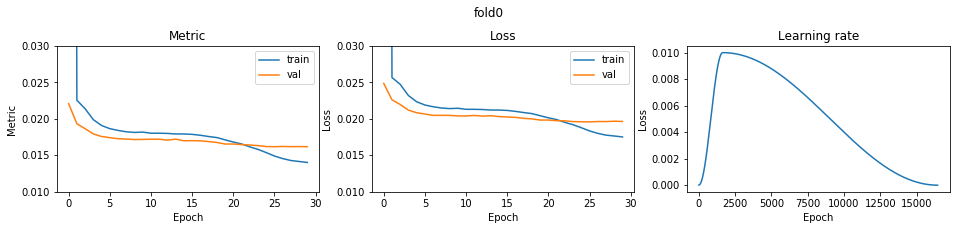

fold 1


epoch,train loss,train metric,val loss,val metric,time
1,0.440633,0.4398018225,0.024858,0.0221473247,0:3
2,0.025474,0.0223516812,0.022492,0.0192223946,0:3
3,0.024345,0.0210033498,0.022290,0.0189630026,0:3
4,0.023003,0.0196947966,0.021169,0.0179838691,0:3
5,0.022115,0.0188505210,0.021025,0.0177614301,0:3
6,0.021824,0.0185712082,0.020825,0.0176074420,0:3
7,0.021580,0.0183216237,0.020844,0.0176141561,0:3
8,0.021417,0.0181525757,0.020822,0.0175376495,0:3
9,0.021292,0.0180206836,0.020597,0.0173721499,0:3
10,0.021286,0.0180047686,0.020592,0.0174073687,0:3


epoch1 save best model... 0.022147324682300577
epoch2 save best model... 0.01922239460760639
epoch3 save best model... 0.018963002628422078
epoch4 save best model... 0.017983869097127028
epoch5 save best model... 0.017761430062487718
epoch6 save best model... 0.017607442006141144
epoch8 save best model... 0.017537649506166167
epoch9 save best model... 0.01737214990875177
epoch11 save best model... 0.017367404479449403
epoch15 save best model... 0.017339047831757978
epoch16 save best model... 0.017191629562086426
epoch20 save best model... 0.01694597270680088
epoch21 save best model... 0.016874438197126855
epoch22 save best model... 0.016789020576205984
epoch23 save best model... 0.016712712444828456
epoch24 save best model... 0.016584606713465337
epoch25 save best model... 0.016547539456872457
epoch26 save best model... 0.016509867527055955
epoch27 save best model... 0.016497290762186756
fold1 score: 0.01649729077875152


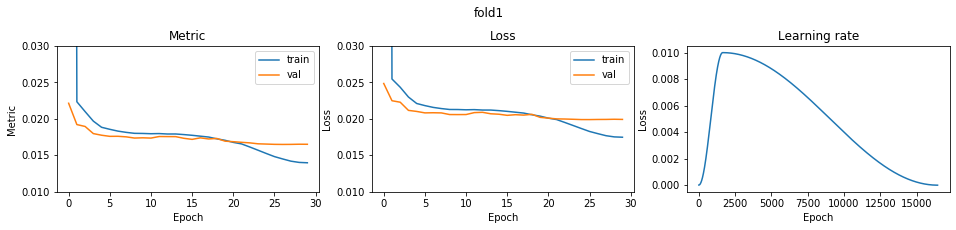

fold 2


epoch,train loss,train metric,val loss,val metric,time
1,0.442331,0.4415122296,0.025936,0.0232262346,0:3
2,0.025788,0.0226468490,0.022533,0.0192899865,0:3
3,0.024583,0.0212417815,0.021840,0.0185292938,0:3
4,0.023180,0.0198650265,0.021483,0.0181785888,0:3
5,0.022395,0.0191271167,0.020952,0.0177029448,0:3
6,0.021906,0.0186516703,0.020974,0.0177082716,0:3
7,0.021711,0.0184652767,0.020621,0.0174281656,0:3
8,0.021510,0.0182523235,0.020628,0.0173539154,0:3
9,0.021415,0.0181530016,0.020547,0.0172619774,0:3
10,0.021476,0.0182086002,0.020714,0.0174930860,0:3


epoch1 save best model... 0.023226234581899496
epoch2 save best model... 0.01928998645726913
epoch3 save best model... 0.018529293821234655
epoch4 save best model... 0.018178588755710587
epoch5 save best model... 0.01770294479912032
epoch7 save best model... 0.017428165577958076
epoch8 save best model... 0.017353915366032015
epoch9 save best model... 0.01726197740956411
epoch11 save best model... 0.01722854927375719
epoch15 save best model... 0.017207319801132197
epoch16 save best model... 0.01712950433594446
epoch17 save best model... 0.01705707822166473
epoch18 save best model... 0.016959110275759706
epoch19 save best model... 0.01687883434799795
epoch20 save best model... 0.01681512390494883
epoch21 save best model... 0.016768017391625204
epoch22 save best model... 0.016552833622539197
epoch23 save best model... 0.016505223284497786
epoch24 save best model... 0.016437719296388147
epoch25 save best model... 0.01634119831786955
epoch26 save best model... 0.01628536467543765
fold2 scor

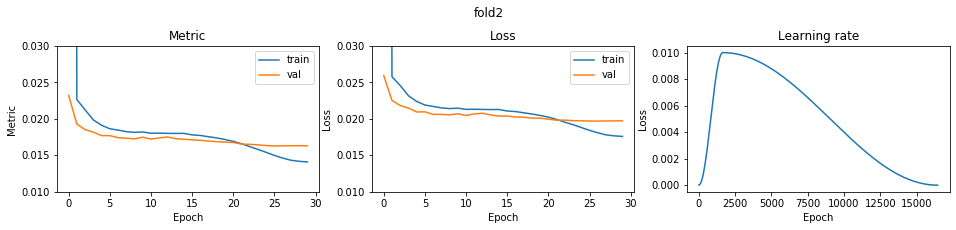

fold 3


epoch,train loss,train metric,val loss,val metric,time
1,0.441541,0.4407134080,0.024634,0.0218616410,0:3
2,0.025720,0.0225567503,0.023335,0.0199467393,0:3
3,0.024430,0.0210733221,0.021873,0.0186156087,0:3
4,0.022958,0.0196461596,0.021274,0.0180148456,0:3
5,0.022132,0.0188694996,0.021013,0.0178125163,0:3
6,0.021806,0.0185543927,0.020956,0.0177658633,0:3
7,0.021567,0.0183166601,0.020830,0.0175701601,0:3
8,0.021423,0.0181579499,0.020790,0.0175874331,0:3
9,0.021293,0.0180217524,0.020709,0.0174291643,0:3
10,0.021291,0.0180095790,0.020750,0.0175592811,0:3


epoch1 save best model... 0.02186164095369857
epoch2 save best model... 0.019946739304564674
epoch3 save best model... 0.018615608671277015
epoch4 save best model... 0.018014845591471245
epoch5 save best model... 0.01781251632177816
epoch6 save best model... 0.017765863256736878
epoch7 save best model... 0.017570160095132292
epoch9 save best model... 0.017429164315071084
epoch11 save best model... 0.01740113547737954
epoch15 save best model... 0.017328165285289288
epoch17 save best model... 0.017198192096126514
epoch18 save best model... 0.017079595756422143
epoch19 save best model... 0.016998963180615445
epoch20 save best model... 0.016822907522507435
epoch22 save best model... 0.016727668279463717
epoch23 save best model... 0.016583288351078106
epoch24 save best model... 0.01650586406104182
epoch25 save best model... 0.016414942757008017
epoch27 save best model... 0.01637089698955179
epoch28 save best model... 0.016366141429913477
epoch29 save best model... 0.01636195195741222
fold3 

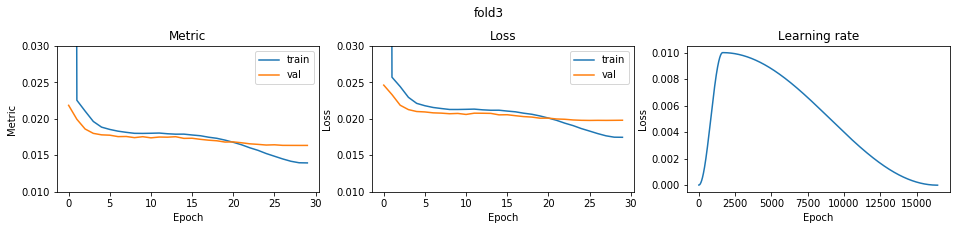

fold 4


epoch,train loss,train metric,val loss,val metric,time
1,0.438520,0.4376904253,0.024889,0.0221476522,0:3
2,0.025891,0.0227647532,0.022471,0.0191339337,0:3
3,0.024593,0.0212688379,0.021651,0.0183713024,0:3
4,0.023210,0.0199082377,0.021120,0.0178381400,0:3
5,0.022226,0.0189626402,0.020821,0.0176265539,0:3
6,0.021777,0.0185239240,0.020861,0.0177019336,0:3
7,0.021540,0.0182845956,0.020768,0.0175009341,0:3
8,0.021438,0.0181718576,0.020525,0.0173571037,0:3
9,0.021422,0.0181558956,0.020569,0.0173279611,0:3
10,0.021375,0.0181020593,0.020603,0.0173430054,0:3


epoch1 save best model... 0.02214765219200309
epoch2 save best model... 0.01913393374600348
epoch3 save best model... 0.018371302427422756
epoch4 save best model... 0.01783814004756052
epoch5 save best model... 0.01762655388419612
epoch7 save best model... 0.017500934127404232
epoch8 save best model... 0.017357103717099698
epoch9 save best model... 0.01732796108761722
epoch11 save best model... 0.017291506938636302
epoch13 save best model... 0.017253955440056895
epoch16 save best model... 0.017176254285427323
epoch17 save best model... 0.01715248352200947
epoch18 save best model... 0.017088255219602774
epoch19 save best model... 0.016973804242925928
epoch20 save best model... 0.01696690865633224
epoch21 save best model... 0.01671405560411258
epoch22 save best model... 0.016666376760021567
epoch23 save best model... 0.016603852516137795
epoch24 save best model... 0.016484792688797847
epoch25 save best model... 0.01648129488517592
epoch26 save best model... 0.016394209916064842
epoch29 s

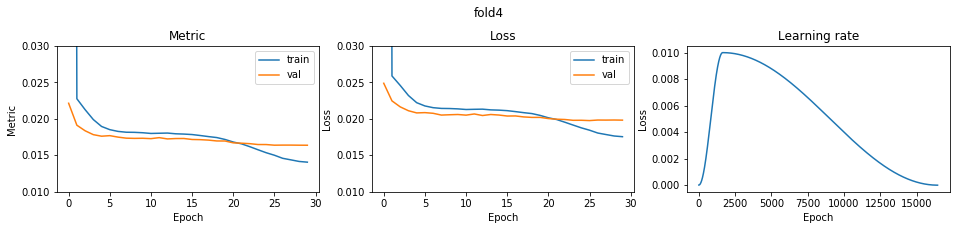

CV score: 0.016342820048774895


In [18]:
oof, predictions = run_kfold_nn(CFG, trn_df, test_df, CFG.feature_cols, CFG.target_cols, n_fold=5)

In [19]:
# OOF score without 'ctl_vehicle'
ys = trn_df[y_keys]
preds = oof

score = compute_metric(preds, ys)
logger.info(f"OOF result: {score}")

OOF result: 0.016342820048774877


In [20]:
ys = trn_df[y_keys]
trn_df[y_keys] = pd.DataFrame(oof)
trn_df[['sig_id'] + y_keys].to_csv('oof.csv', index=False)

test_df[y_keys] = pd.DataFrame(predictions)
test_df[['sig_id'] + y_keys].to_csv('pred.csv', index=False)

In [21]:
# Final result with 'cp_type'=='ctl_vehicle' data
result = trn_tar_df.drop(columns=y_keys).merge(trn_df[['sig_id']+y_keys], on='sig_id', how='left').fillna(0)

ys = trn_tar_df[y_keys].values
preds = result[y_keys].values

score = compute_metric(preds, ys)
logger.info(f"Final result: {score}")

Final result: 0.015062241304716194


In [22]:
sub = sub_df.drop(columns=y_keys).merge(test_df[['sig_id'] + y_keys], on='sig_id', how='left').fillna(0)
sub.to_csv('submission.csv', index=False)
sub.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.000871,0.002207,0.001916,0.011197,0.021782,0.006051,0.001444,0.005131,0.000381,...,0.001195,0.001289,0.003377,0.000315,0.000547,0.001104,0.000343,0.001941,0.002346,0.001643
1,id_001897cda,0.000570,0.001162,0.001869,0.001192,0.001017,0.001576,0.004711,0.008342,0.006465,...,0.000885,0.001027,0.003585,0.000128,0.006971,0.000763,0.002625,0.000835,0.001343,0.002915
2,id_002429b5b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_00276f245,0.001160,0.001081,0.002778,0.012390,0.010879,0.004850,0.002983,0.003894,0.000454,...,0.001221,0.001510,0.003207,0.018664,0.006603,0.001258,0.001682,0.003355,0.000487,0.002435
4,id_0027f1083,0.002473,0.001996,0.001858,0.012492,0.022204,0.004124,0.005442,0.001539,0.000472,...,0.000976,0.000546,0.004293,0.002548,0.000899,0.000845,0.000935,0.002272,0.000127,0.001133
